In [1]:
using QuantumOptics
using IonSim

import PyPlot
const plt = PyPlot

using Statistics
const stats = Statistics;

Consider:
- Two ions
- A single vibrational mode
- Bichromatic light $\longleftarrow \textbf{Q}:$ This means red and blue sidebands, right?
- In a rotating frame $\longleftarrow \textbf{Q}:$  This means we've used RWA, right?

$\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

Where:
- $i$ indexes the lasers
- $\Omega$ is the strength of the laser-ion interaction $\longleftarrow \textbf{Q}:$ Is this the same as the Rabi frequency? Both IonSim and Roos thesis call it a coupling constant.
- $\hat{\sigma}_+^{(j)}$ = electronic raising operator of the j-th ion. Note: Ions are being modeled as 2-level systems, having levels $\ket{1}$ and $\ket{2}$, so $\hat{\sigma}_+ = \ket{2}\bra{1}$.
- $\eta$ = *Lamb-Dicke* factor: characterizes strength of coupling between ion's internal electronic state and it's vibrational mode/motion.
- $a$ is the Boson annihilation operator for the vibrational mode. 
- $\nu$ is the vibrational mode frequency $\longleftarrow \textbf{Q}:$ I've seen other sources use $\nu$ to represent the *transition frequency* (e.g. Roos equation 3.2) - is that just different notation?
- $\Delta_i$ is "the detuning of the $i^{th}$ laser from the electronic energy splitting of the ion (assummed to be the same for both ions)."
    - See Roos pg. 14 for significance of detuning. If detuning is zero, then oscillation consists of a complete population transfer between $\ket{1}$ and $\ket{2}$, at the Rabi frequency. At small-but-non-zero detuning (i.e. slightly off-resonance), "the population transfer is no longer complete, yet it takes place at a higher frequency".
- $\phi_i$ is the phase of the $i^{th}$ laser. 
    - Recall Brant: Axis of rotation depends on the phase.

"Assuming $\Delta_{1,2} = \pm (\nu + \epsilon)$, then, under the right conditions, $\textit{this interaction can be used to produce a maximally entangled Bell state of the two ions}$."

"However, in \textit{Ion-trap quantum gates with amplitude-modulated laser beams}, it's shown that a poor choice of the relative phase $\Delta \phi = \phi_1 - \phi_2$ between the two lasers can impact the quality of this process by amplifying the effect of off-resonant carrier transitions" $\longleftarrow \textbf{Q:}$ Is this in line with my current understanding of the phase? That it determines the axis of rotation?

"Fortunately, by ramping up the amplitudes of the lasers, we can eliminate this dependency on. In practice any smooth ramp that lasts a duration long relative to the period of the ion’s motion is sufficient.

In this notebook, we examine this effect, which will demonstrate how to construct time-dependent laser intensity in IonSim."

# Correlated Phase

## Construct the system

In [2]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
# useful for modeling crosstalk. In practice, focusing on one ion but, say 10% amplitude at neighbor ion. 

Laser(missing, IonSim.var"#It#31"{Int64}(0), 0, (x = 0.7071067811865475, y = 0.7071067811865475, z = 0.0), (x = 0, y = 0, z = 1), IonSim.var"#ϕt#32"{Int64}(0), [(1, 1.0), (2, 1.0)])

In [3]:
ion1 = ca 
ion2 = ca

⁴⁰Ca

In [4]:
chain = LinearChain(
        ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


LinearChain(2 ions)

In [5]:
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

In [6]:
# For some reason these commented out lines yield fudgey results
# Is it the precision?
# λ_trans = transitionwavelength(ca, ("S1/2", "D5/2"), chamber)
# laser1.λ = λ_trans
# laser2.λ = λ_trans

# Set wavelengths
wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)

# Set detunings
vibrational_mode = modes(chamber)[1]
ν = frequency(vibrational_mode)

ϵ = 10e3 # <-- not sure what this is for
d = 0#350 # corrects for AC stark shift from single-photon coupling to sidebands
Δ_blue = ν + ϵ - d
Δ_red = -(ν + ϵ - d)

laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red # red sideband

# Set polarizations, wavevectors
# B-field polarized between x and z. That has something to do with our
# choice of polarization and wavevector, but not 100% sure of the relation
laser1.ϵ = x̂
laser1.k = ẑ

laser2.ϵ = x̂
laser2.k = ẑ

# Set the laser intensity for pi-pulse in t=η/ϵ=1/(2Ω)  <-- Also not sure where this comes from
η = abs(lambdicke(vibrational_mode, ca, laser1))
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ
intensity_from_pitime!(1, pi_time, 1, ("S", "D"), chamber)
intensity_from_pitime!(2, pi_time, 1, ("S", "D"), chamber);

In [37]:
intensity_from_pitime(1, pi_time, 1, ("S", "D"), chamber)

87827.42930374204

In [38]:
η = abs(lambdicke(vibrational_mode, ca, laser1))

0.1370444881340198

In [39]:
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ

1.3704448813401979e-5

In [41]:
ϵ

10000.0

In [7]:
pi_time

1.3704448813401979e-5

In [8]:
intensity_from_pitime(1, pi_time, 1, ("S", "D"), chamber)

87827.42930374204

In [9]:
DETUNING_ANGULAR = 1e4   # 1e4!! not 1e3
DETUNING = 2π*DETUNING_ANGULAR # Hz
GATE_TIME = 1/DETUNING # seconds

1.5915494309189534e-5

In [10]:
pi_time

1.3704448813401979e-5

In [11]:
# setup the Hamiltonian
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

# solve system
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:105, ca["S"] ⊗ ca["S"] ⊗ vibrational_mode[0], h);

  3.445494 seconds (14.34 M allocations: 903.582 MiB, 8.46% gc time, 96.68% compilation time)


In [14]:
function get_bell_state_fidelity(state)
    bell_state_electronic = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2)
    rho = dm(state)
    rho_electronic = ptrace(rho, 3)
    fid = fidelity(rho_electronic, bell_state_electronic)
    return fid 
end

get_bell_state_fidelity (generic function with 1 method)

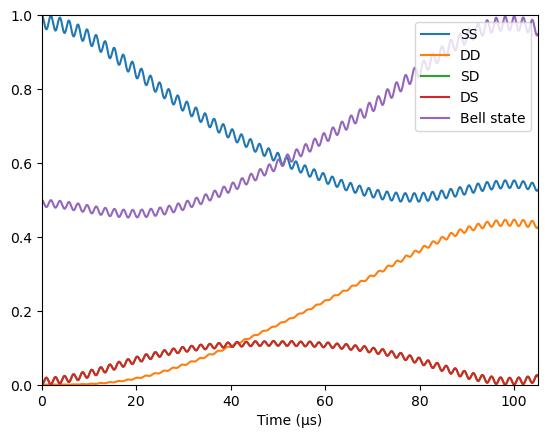

Bell-state fidelity: 0.9740337444069662
Gate-time: 105.0 μs 
Intensity: 87827.42930374204 W/m^2 


In [26]:
SS = ionprojector(chamber, "S", "S") 
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Gate-time: ", tout[end], " μs \n")


In [43]:
propertynames(h)

(:S, :δνfuncs, :δνi, :bfunc, :gbs, :gbi, :aui, :cindxs, :indxs, :b)

In [66]:
chamber.lasers[1].pointing

2-element Vector{Tuple{Int64, Float64}}:
 (1, 1.0)
 (2, 1.0)

In [58]:
I_pitime = intensity_from_pitime(1, η / DETUNING_ANGULAR , 1, ("S", "D"), chamber)

87827.42930374204

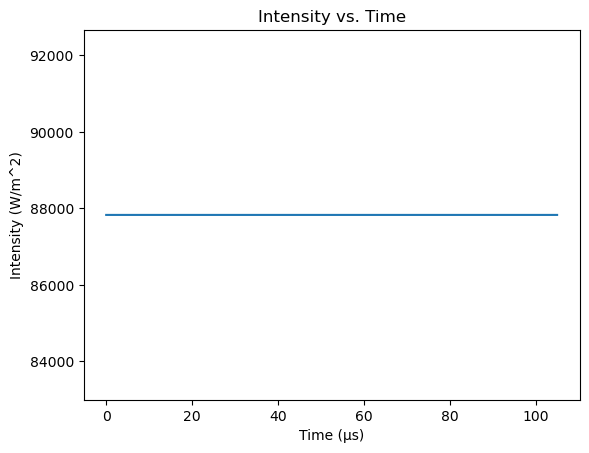

In [28]:
I_range = zeros(length(tout))
idx = 0

for t in tout
    idx += 1
    I_range[idx] = laser1.I(t)
end

fig  = plt.figure()
plt.plot(tout, I_range)
plt.xlabel("Time (μs)")
plt.ylabel("Intensity (W/m^2)")
plt.title("Intensity vs. Time")
plt.display(fig)

In [36]:
stats.mean(I_range)

87827.42930374204

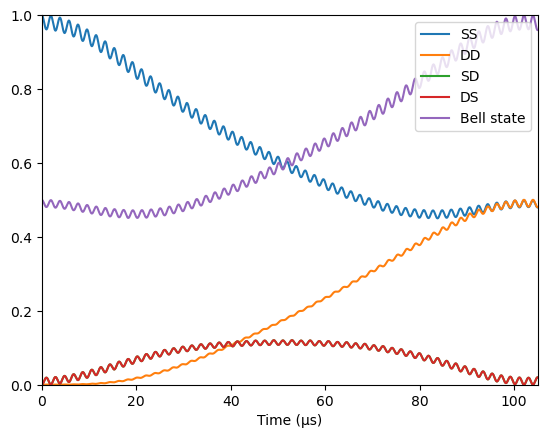

In [9]:
SS = ionprojector(chamber, "S", "S") 
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

In [10]:
ca["S"] ⊗ ca["S"] 

Ket(dim=4)
  basis: [⁴⁰Ca ⊗ ⁴⁰Ca]
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [11]:
dm(ca["S"] ⊗ ca["S"] +  1im * ca["D"] ⊗ ca["D"])

Operator(dim=4x4)
  basis: [⁴⁰Ca ⊗ ⁴⁰Ca]
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0-1.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+1.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im

In [12]:
one(vibrational_mode)

Operator(dim=11x11)
  basis: VibrationalMode(ν=250000.0, axis=ẑ, N=10)
Eye(11)

In [12]:
propertynames(bell_state)

(:basis_l, :basis_r, :data)

In [28]:
bell_state

Operator(dim=44x44)
  basis: [⁴⁰Ca ⊗ ⁴⁰Ca ⊗ VibrationalMode(ν=250000.0, axis=ẑ, N=10)]
 0.5+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.5im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0

In [32]:
dm(sol[end])

Operator(dim=44x44)
  basis: [⁴⁰Ca ⊗ ⁴⁰Ca ⊗ VibrationalMode(ν=250000.0, axis=ẑ, N=10)]
    0.479672+0.0im          …    1.62124e-7+7.05938e-7im
   0.0683661-0.0657666im         1.19896e-7+7.83868e-8im
   0.0683661-0.0657666im         1.19896e-7+7.83868e-8im
  -0.0174522+0.479614im         -7.11752e-7+1.3642e-7im
 -0.00495631-0.00410115im        4.36054e-9-8.6804e-9im
   0.0213383-0.0113741im    …    2.39515e-8+2.75595e-8im
   0.0213383-0.0113741im         2.39515e-8+2.75595e-8im
 -0.00474049-0.00433866im        4.78302e-9-8.44305e-9im
 -0.00130034+0.000171316im     -6.91629e-10-1.85582e-9im
  8.18979e-5+6.3965e-5im       -6.64574e-11+1.4215e-10im
            ⋮               ⋱  
  5.56269e-7+1.37448e-6im   …  -1.83483e-12+1.28323e-12im
 -1.26845e-7+1.44419e-7im       -2.5541e-13-1.3787e-13im
 -3.60158e-7-6.77928e-7im        8.7599e-13-7.5918e-13im
 -3.60158e-7-6.77928e-7im        8.7599e-13-7.5918e-13im
 -1.85389e-7+5.86583e-8im       -1.4899e-13-2.5301e-13im
 -1.38281e-7+7.0732e-7im  

# Anti-correlated phase

In [10]:
bell_rho = dm(bell_state)

MethodError: MethodError: no method matching dm(::Operator{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, Matrix{ComplexF64}})

Closest candidates are:
  dm(!Matched::QuantumOptics.semiclassical.State)
   @ QuantumOptics C:\Users\abdel\.julia\packages\QuantumOptics\9adUY\src\semiclassical.jl:52
  dm(!Matched::Ket)
   @ QuantumOpticsBase C:\Users\abdel\.julia\packages\QuantumOpticsBase\kRvbo\src\operators_dense.jl:279
  dm(!Matched::Bra)
   @ QuantumOpticsBase C:\Users\abdel\.julia\packages\QuantumOpticsBase\kRvbo\src\operators_dense.jl:280


In [12]:
phase!(laser1, -π/2)
phase!(laser2, π/2);

In [13]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

In [14]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ca["S"] ⊗ ca["S"] ⊗ mode[0], h);

UndefVarError: UndefVarError: `mode` not defined

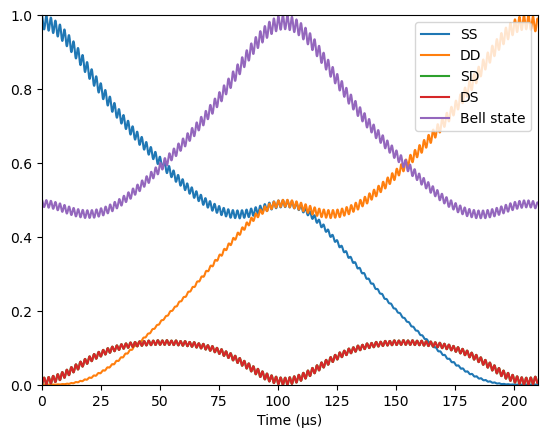

In [15]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

# Anti-correlated phase with ramped laser intensity

In [16]:
I = intensity_from_pitime(1, pi_time, 1, ("S", "D"), chamber)
# Simple amplitude ramping function
Ω = t -> t < 20 ? sin(2π * t / 80)^2 : 1

intensity!(laser1, t -> I*Ω(t)^2)
intensity!(laser2, t -> I*Ω(t)^2);

In [17]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);

In [18]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:220, ca["S"] ⊗ ca["S"] ⊗ mode[0], h);

UndefVarError: UndefVarError: `mode` not defined

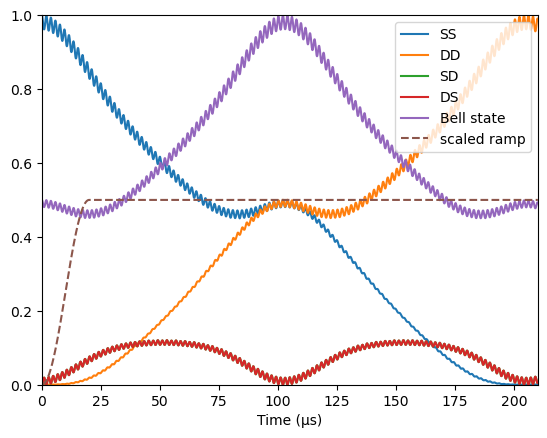

In [19]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.plot(
        tout, @.(Ω(tout) / 2), 
        linestyle="--", label="scaled ramp"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

In [20]:
propertynames(chamber)

(:iontrap, :B, :Bhat, :∇B, :δB, :lasers, :_cnst_δB)

In [21]:
propertynames(chain)

(:ions, :comfrequencies, :selectedmodes, :ionpositions)

In [22]:
chain.comfrequencies

(x = 3.0e6, y = 3.0e6, z = 250000.0)

In [23]:
chain.selectedmodes

(x = VibrationalMode[], y = VibrationalMode[], z = VibrationalMode[VibrationalMode(ν=250000.0, axis=ẑ, N=10)])